###Import Libraries 

In [1]:
#import relevant libraries 
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras import callbacks, models, layers, regularizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from skimage.filters import gaussian
from skimage.util import random_noise
import matplotlib.image as mpimg
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, accuracy_score, confusion_matrix, plot_roc_curve, \
make_scorer, recall_score, precision_score, f1_score
import tqdm
import cv2
import os
from os import walk
import numpy as np
import time
import pandas as pd
import tensorflow as tf
import scipy
from scipy import ndimage
from PIL import Image
import shutil
import itertools

import warnings
warnings.filterwarnings('ignore')

from numpy.random import seed
seed(42)


## Data Exploration 
--- 
The original dataset consisted of 162 whole mount slide images of Breast Cancer (BCa) specimens scanned at 40x magnification. From that, about 300,000 patches of size 50 x 50 were extracted (About 200k IDC negative and about 80k IDC positive).

Before doing any data preparation, I wanted to see what images I was working with to see if the difference between malignant and normal cells was discernable to my naked eye. To do this, I created a subset folder "DataNew" using 6 random patient's images. 

In [ ]:
#Before sorting and preparing the data I wanted to view it
#Create directory for images, name path, and store images 
cancer_rays_dir     = os.listdir("/content/drive/MyDrive/Breast_Histopathology_dataset/DataNew") 
all_rays_dir        = "all_rays_dir"  # is this path we will put all the images
cancer_rays_dir_str = "/content/drive/MyDrive/Breast_Histopathology_dataset/DataNew/"

In [ ]:
#show patient ID and number of patients used
print(cancer_rays_dir)
print(len(cancer_rays_dir)) 

['10277', '9227', '9323', '10300', '10256', '10278']
6


In [ ]:
#sort images, adding a positive and negative indicator (0=Normal, 1=Cancerous)
for patient in cancer_rays_dir:   
    path_0 = cancer_rays_dir_str + str(patient) + '/0'
    path_1 = cancer_rays_dir_str + str(patient) + '/1'
    file_list_0 = os.listdir(path_0)   
    file_list_1 = os.listdir(path_1)
    for fname in file_list_0:
            src = os.path.join(path_0, fname)
            dst = os.path.join(all_rays_dir, fname)
            shutil.copyfile(src, dst)
    for fname in file_list_1:
        src = os.path.join(path_1, fname)
        dst = os.path.join(all_rays_dir, fname)
        shutil.copyfile(src, dst)

In [ ]:
#number of sample images taken in from these 6 patients 
all_rays_dir_lst = os.listdir('./all_rays_dir') 
len(all_rays_dir_lst)

7135

In [ ]:
#check for naming convention 
data = pd.DataFrame(all_rays_dir_lst, columns=['image_id'])
data.head()

,image_id
0,10277_idx5_x701_y2001_class0.png
1,10277_idx5_x701_y951_class0.png
2,10300_idx5_x1201_y1701_class0.png
3,9323_idx5_x351_y1701_class0.png
4,10256_idx5_x751_y251_class0.png


In [ ]:
#using added indicator, divide data and create target (0=Normal, 1=Cancerous)
def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5] 
    return target

data['target'] = data['image_id'].apply(extract_target)

data.head(10)

,image_id,target
0,10277_idx5_x701_y2001_class0.png,0
1,10277_idx5_x701_y951_class0.png,0
2,10300_idx5_x1201_y1701_class0.png,0
3,9323_idx5_x351_y1701_class0.png,0
4,10256_idx5_x751_y251_class0.png,0
5,9323_idx5_x1501_y1001_class0.png,0
6,9323_idx5_x1551_y201_class0.png,0
7,10277_idx5_x901_y1601_class1.png,1
8,9323_idx5_x1551_y451_class0.png,0
9,9323_idx5_x351_y701_class0.png,0


In [ ]:
#glean and create column for patient ID
def extract_patient_id(x):
    # split into a list
    a = x.split('_')
    patient_id = a[0]
    
    return patient_id
data['patient_id'] = data['image_id'].apply(extract_patient_id)
data.head()

,image_id,target,patient_id
0,10277_idx5_x701_y2001_class0.png,0,10277
1,10277_idx5_x701_y951_class0.png,0,10277
2,10300_idx5_x1201_y1701_class0.png,0,10300
3,9323_idx5_x351_y1701_class0.png,0,9323
4,10256_idx5_x751_y251_class0.png,0,10256


In [ ]:
#get total count of cancerous and non cancerous 
data['target'].value_counts()

0    6303
1     832
Name: target, dtype: int64

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


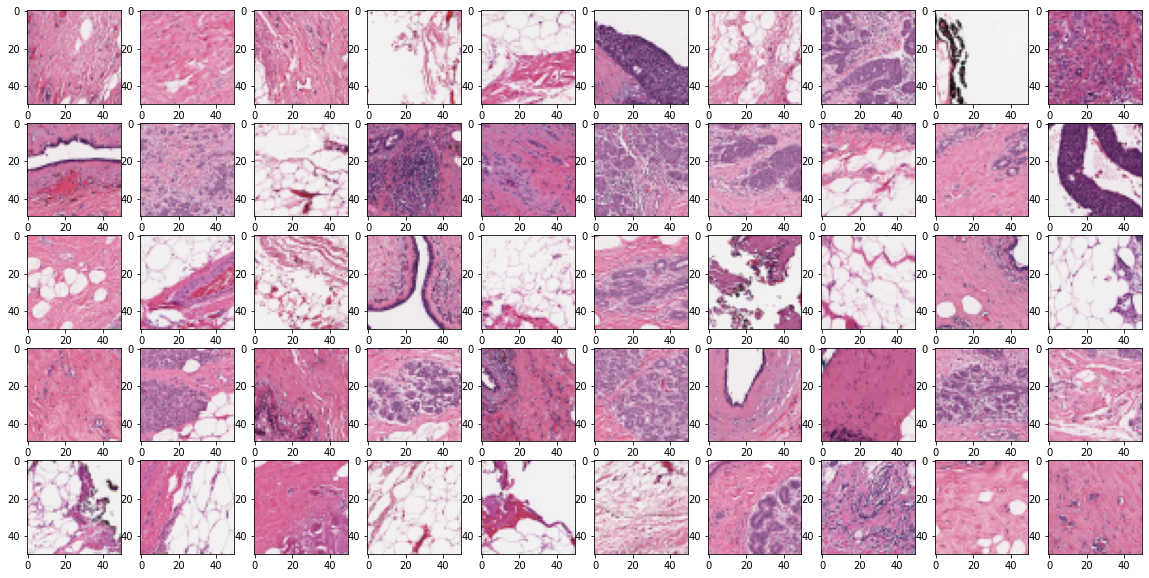

In [ ]:
#show normal cell images 
data.target = data.target.astype(np.int)
fig, ax = plt.subplots(5,10,figsize=(20,10))
pos_selection = np.random.choice(data[data.target ==1].index, size=50, replace=False,)
neg_selection = np.random.choice(data[data.target ==0].index, size=50, replace=False,)
for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10*n]
        path =os.path.join(all_rays_dir,data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

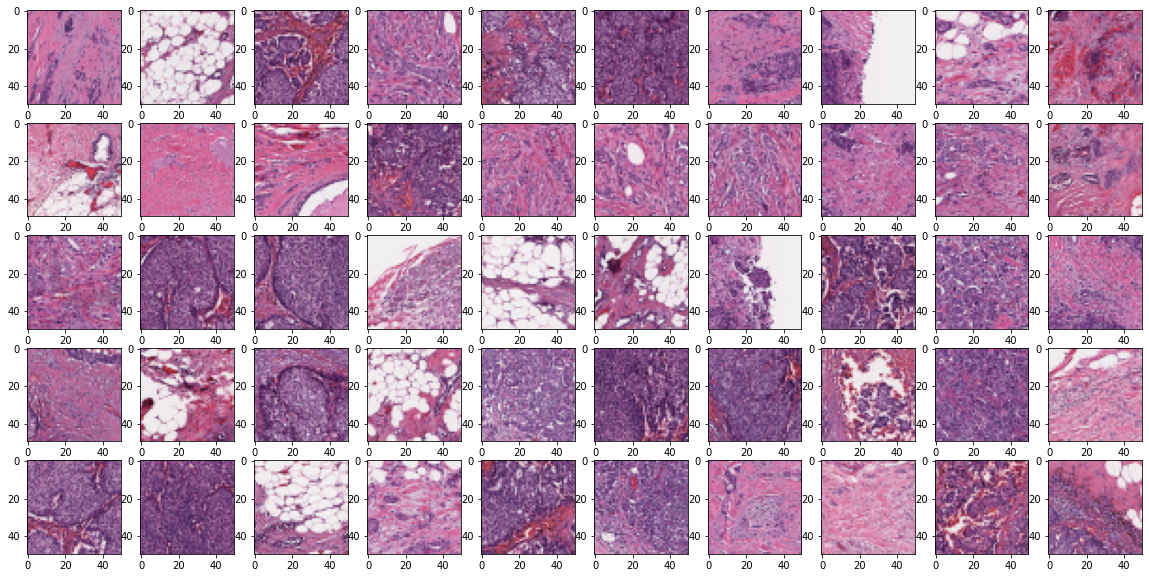

In [ ]:
#show malignant cell images 
fig, ax = plt.subplots(5,10,figsize=(20,10))
for n in range(5):
    for m in range(10):
        idx = pos_selection[m + 10*n]
        path =os.path.join(all_rays_dir,data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

Although looking at the cells all together, you may notice the malignant cells are typically darker and contain more purple and less light pink, I don't think I would feel confident at all picking out cancerous vs normal If I was presented an unknown cell one at a time.

## Data Preparation 
--- 
As previously stated, the original dataset consisted of 162 whole mount slide images of Breast Cancer (BCa) specimens scanned at 40x magnification. From that, about 300,000 patches of size 50 x 50 were extracted (About 200k IDC negative and about 80k IDC positive). This is far too many images for my computer to handle. 


In order to create a digestible size of data, I randomly selected images and randomly sorted them into my Test, Train, and Validation sets, each containing two subset folders: Cancer and Normal.

Outside of organizing, there was little data preparation to be done with the images themselves. First, I wrote a function to pull in the data from the folders I created and saved on google drive. This funciton resized and labeled each image as it was pulled in. 

In [2]:
#function to pull in data, resize image, and label as either "cancerous" or "normal"

labels = ['CANCEROUS', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [3]:
#using the function above, pull in the labeled and resized images, and assign to
#train, test, or val 

train = get_training_data('/content/drive/MyDrive/Breast_Histopathology_dataset/Dataset/train')
test = get_training_data('/content/drive/MyDrive/Breast_Histopathology_dataset/Dataset/test')
val = get_training_data('/content/drive/MyDrive/Breast_Histopathology_dataset/Dataset/val')

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



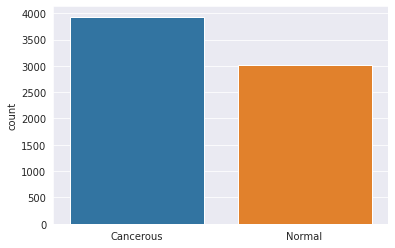

In [4]:
# get total count of Cancerous and Normal sample images 
get_count = []
for i in train:
    if(i[1] == 0):
        get_count.append("Cancerous")
    else:
        get_count.append("Normal")
sns.set_style('darkgrid')
sns.countplot(get_count) 

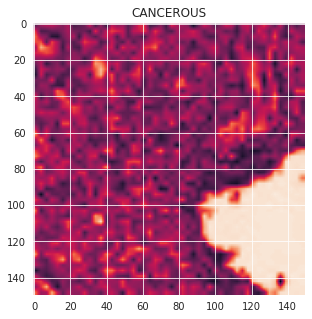

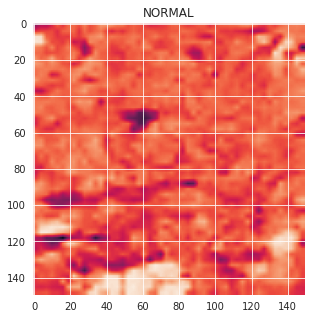

In [5]:
#compare processed cancerous and normal images 
plt.figure(figsize = (5,5))
plt.imshow(train[0][0])
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]]);

In [6]:
#create data splits for training/testing
#x will contain the image itself 
#y will contain its classification label (Cancerous(1) or Normal(0) )
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [7]:
#Normalize the data
x_train = np.array(x_train) / 253
x_val = np.array(x_val) / 253
x_test = np.array(x_test) / 253

In [8]:
#check current shape
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

(6958, 150, 150)
(869, 150, 150)
(107, 150, 150)


In [9]:
#reshaping data for logistic regression
train_img = x_train.reshape(x_train.shape[0], -1)
test_img = x_test.reshape(x_test.shape[0], -1)
val_img = x_val.reshape(x_val.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)




(6958, 22500)
(869, 22500)
(107, 22500)


In [10]:
# resize and reshape data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

(6958, 150, 150, 1)
(869, 150, 150, 1)
(107, 150, 150, 1)


In [11]:
# Show shape and number of images in train, test ,and val

m_train = x_train.shape[0]
num_px = x_train.shape[1]
m_test = x_test.shape[0]
m_val = x_val.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(x_train.shape))
print ("train_labels shape: " + str(y_train.shape))
print ("test_images shape: " + str(x_test.shape))
print ("test_labels shape: " + str(y_test.shape))
print ("val_images shape: " + str(x_val.shape))
print ("val_labels shape: " + str(y_val.shape))

Number of training samples: 6958
Number of testing samples: 869
Number of validation samples: 107
train_images shape: (6958, 150, 150, 1)
train_labels shape: (6958,)
test_images shape: (869, 150, 150, 1)
test_labels shape: (869,)
val_images shape: (107, 150, 150, 1)
val_labels shape: (107,)


We see above, before data generation/image augmentation, there are approximately 7,000 training images, 1,000 testing images, and 100 validation images. 

CNN typically requires a LOT more images to train, but due to computing capactiy and time constraints, I will be augmenting these 8,000 images instead of adding more. 

###**Image Augmentation/Data Generation**

In [12]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 across entire dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by SD of dataset
        samplewise_std_normalization=False,  # divide each input by its own SD
        horizontal_flip = True,  # randomly flip images over horizontal axis
        vertical_flip=False)  # randomly flip images over vertical axis
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (0 to 180 degrees)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
       


datagen.fit(x_train)

In [ ]:
# 

##**Data Modeling**
---


#### **Model 1: Logistic Regression (Simple Baseline Model)** 
After exploring the data and building in extra data generation/image augmentation, the first model I created was a simple logistic regression model. A Logistic regression model estimates the probability of an event occurring, "cancerous" or "normal". This scored surprisingly well, at 83% accuracy and 78% recall.

0.8319907940161104
0.7867867867867868


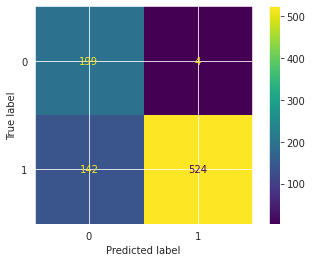

In [13]:
# Baseline Logistic Regression

lr = LogisticRegression(random_state = 42)

lr.fit(train_img, y_train)

print(lr.score(test_img, y_test))

y_pred = lr.predict(test_img)

print(recall_score(y_test, y_pred))

plot_confusion_matrix(lr, test_img, y_test)
plt.show()

Next, we will try out a convolutional neural network (CNN) model, which is a powerful deep learning model commonly used for image classification. 

#### **Model 2: Baseline Convolutional Neural Network(CNN) Model** 

In [14]:
# Baseline Model

model = models.Sequential()
model.add(layers.Dense(20, activation='relu', input_shape=(22500,))) # 2 hidden layers
model.add(layers.Dense(7, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='sgd',
             loss = 'binary_crossentropy',
             metrics =  ['accuracy', tf.keras.metrics.Recall()])

histoire = model.fit(train_img,
                    y_train,
                    epochs = 50,
                    batch_size = 32,
                    validation_data=(val_img,y_val))

print(f"\nTraining Score: {model.evaluate(train_img, y_train)}")
print(f"\nTest Score: {model.evaluate(test_img, y_test)}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                450020    
                                                                 
 dense_1 (Dense)             (None, 7)                 147       
                                                                 
 dense_2 (Dense)             (None, 5)                 40        
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 450,213
Trainable params: 450,213
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
218/218 [==============================] - 3s 8ms/step - loss: 0.6863 - accuracy: 0.6554 - recall: 0.6843 - val_loss: 0.6681 - val_accuracy: 0.9720 - val_recall: 1.0000
Ep

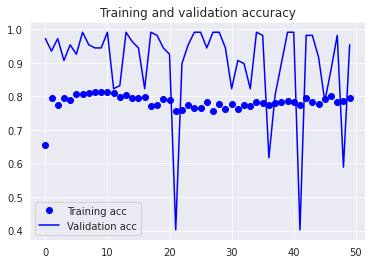

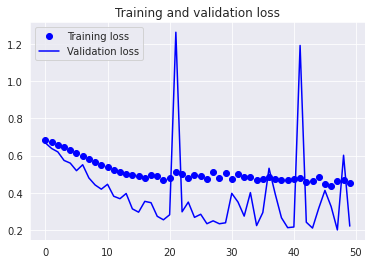

In [15]:
# Plots

acc = histoire.history['accuracy']
val_acc = histoire.history['val_accuracy']
loss = histoire.history['loss']
val_loss = histoire.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


Moving into deep learning models, my baseline convolution neural network produced some interesting results. The training data scored with 83% accuracy and 95% recall, yet the test data scored with 90% accuracy and 88% recall. Looking at the accuracy and loss in my graphs, I was expecting to see okay scores with some overfitting happening. I didn't expect them to be this good.

This could be due to the nature of my data split. As I said earlier, to create a workable data size I randomy selected samples from only a few (4-6) patients for my test set, which may have been easier to classify than the entire sub-population(15-20 patients) I was using to train my model. Thus, perhaps, my model is not very generalizable. This could be explored in future testing.

There is definitely something unsettling about this. If I had more time, and each model didn't take 90 minutes run, I would spend more time exploring this. Further, I would add in more data and even explore an entirely new dataset. 

#### **Model 3: CNN Model - Addition of MaxPool2d and Conv2d layers**

MaxPool2d is a pooling operation for 2d data. It downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input. The window then shifts by "strides" along each dimension.

Conv2d creates a convolutional layer, converting the layer inputs to a tensor of outputs.

In [19]:
# Conv2d and MaxPool2D Model

model = models.Sequential()
model.add(layers.Conv2D(32 , (3,3), strides = 1, activation='relu', input_shape=(150,150,1)))
model.add(layers.MaxPool2D((2,2), strides = 2))


model.add(layers.Conv2D(64, (3,3), strides = 1, activation='relu'))
model.add(layers.MaxPool2D((2,2), strides = 2))


model.add(layers.Conv2D(64, (3,3), strides = 1, activation='relu'))
model.add(layers.MaxPool2D((2,2), strides = 2))


model.add(layers.Conv2D(128, (3,3), strides = 1, activation='relu'))
model.add(layers.MaxPool2D((2,2), strides = 2))

model.add(layers.Conv2D(256, (3,3), strides = 1, activation='relu'))
model.add(layers.MaxPool2D((2,2), strides = 2))

model.add(layers.Flatten())

model.add(layers.Dense(units=128, activation='relu'))


model.add(layers.Dense(units=1, activation='sigmoid'))

model.summary()

model.compile(optimizer='sgd',
             loss = 'binary_crossentropy',
             metrics =  ['accuracy', tf.keras.metrics.Recall()])

histoire = model.fit(x_train,
                    y_train,
                    epochs = 20, 
                    steps_per_epoch= 80,
                    batch_size = 32,
                    validation_data=(x_val,y_val))

print(f"\nTraining Score: {model.evaluate(x_train, y_train)}")
print(f"\nTest Score: {model.evaluate(x_test, y_test)}")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 17, 17, 64)      

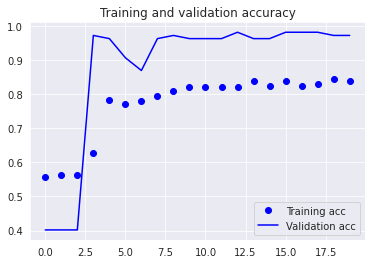

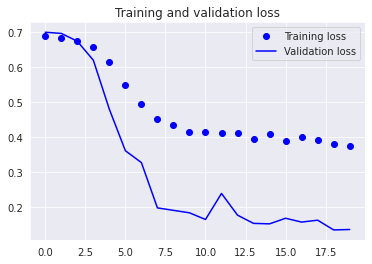

In [20]:
# Plots

acc = histoire.history['accuracy']
val_acc = histoire.history['val_accuracy']
loss = histoire.history['loss']
val_loss = histoire.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In my third model, I added MaxPool2d and Conv2d layers. Here we see the training score increase slightly to 84% and the recall decrease to 88%. On the testing data we see the accuracy score decrease to 88% and our recall decrease to 85%. It was conforting to get consistent data, as the previous time I re-ran everything, I got 83 and 88, for accuracy and recall, respectively. 

One more thing to note: Intuition would tell me to drop these additional layers, since they lowered my scores. Despite this, I tried the subsequent model with and without them present and found the scores to be better when they are present. 

#### **Model 4 (Final Model): CNN Model - Change optimizer, add batch normalization, add padding**

Here we changed our optimizer to rmsprop, added batch normalization and padding. 

Rmsprop is an optimizer, which uses an extension of gradient descent called root mean squared propagation. It maintains a moving(discounted) average of the square of gradients, and divides the gradient by the root of this average. Batch normalization is a layer that normalizes its unputs. Further, this layer applies a transformation that maintains the mean output close to 0 and the output SD close to 1. Important to note, it normalizes differently between training and inferencing. Setting Padding = "same" results in zeros evenly dispersed around the input. When strides=1 and padding = "same", the resulting output of the layer will have the same size as the input. 


Despite MaxPool2d and Conv2d lowering the previous model's performance, I found this model performed better with those layers still present. 

In [21]:
#CNN model - changing the optimizer, adding batch normalization and padding 
model = models.Sequential()
model.add(layers.Conv2D(32 , (3,3), strides = 1, padding = 'same', activation='relu', input_shape=(150,150,1)))
model.add(BatchNormalization())
model.add(layers.MaxPool2D((2,2), strides = 2, padding = 'same'))


model.add(layers.Conv2D(64, (3,3), strides = 1, padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPool2D((2,2), strides = 2, padding = 'same'))


model.add(layers.Conv2D(64, (3,3), strides = 1, padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPool2D((2,2), strides = 2, padding = 'same'))


model.add(layers.Conv2D(128, (3,3), strides = 1, padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPool2D((2,2), strides = 2, padding = 'same'))

model.add(layers.Conv2D(256, (3,3), strides = 1, padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPool2D((2,2), strides = 2, padding = 'same'))

model.add(layers.Flatten())

model.add(layers.Dense(units=128, activation='relu'))


model.add(layers.Dense(units=1, activation='sigmoid'))

model.summary()

model.compile(optimizer= "rmsprop",
             loss = 'binary_crossentropy',
             metrics =  ['accuracy', tf.keras.metrics.Recall()])

histoire = model.fit(x_train,
                    y_train,
                    epochs = 20,
                    steps_per_epoch = 80,
                    batch_size = 32,
                    validation_data=(x_val,y_val))

print(f"\nTraining Score: {model.evaluate(x_train, y_train)}")
print(f"\nTest Score: {model.evaluate(x_test, y_test)}")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       256       
 hNormalization)                                                 
                                                      

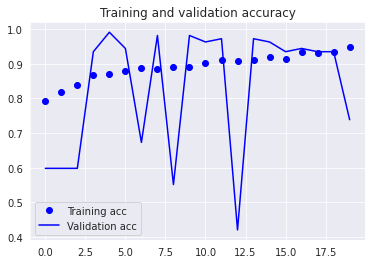

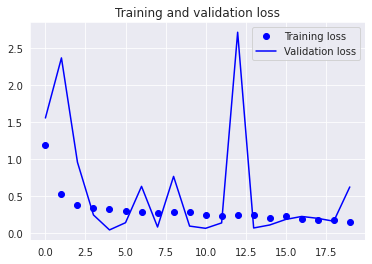

<Figure size 432x288 with 0 Axes>

In [22]:
# Plots

acc = histoire.history['accuracy']
val_acc = histoire.history['val_accuracy']
loss = histoire.history['loss']
val_loss = histoire.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
plt.savefig('/content/drive/MyDrive/Breast_Histopathology_dataset/images', bbox_inches = "tight")

In [27]:
#set up data for confusion matrix of results
predictions = model.predict(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

array([1.38245225e-01, 2.28595734e-03, 1.88930333e-02, 5.02002537e-02,
       2.97576189e-04, 9.95145321e-01, 3.49328802e-05, 6.92558169e-05,
       6.40133023e-02, 1.33807361e-01, 6.50819061e-07, 1.12543434e-01,
       6.09634817e-02, 3.30473013e-05, 1.44613836e-07], dtype=float32)

In [31]:
p_pred = model.predict(x_test)
p_pred = p_pred.flatten()
print(p_pred.round(2))
# [1. 0.01 0.91 0.87 0.06 0.95 0.24 0.58 0.78 ...



[0.14 0.   0.02 0.05 0.   1.   0.   0.   0.06 0.13 0.   0.11 0.06 0.
 0.   0.01 0.   0.   0.99 0.14 0.   0.32 0.02 0.01 0.02 0.   0.06 0.03
 0.03 0.08 0.02 0.02 0.01 0.08 0.   0.58 0.01 0.34 0.01 0.   0.15 0.99
 0.   0.   0.01 0.   0.   0.   0.   0.18 0.03 0.   0.   0.01 0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.11 0.04 0.28 0.   0.15 0.
 0.   0.   0.   0.01 0.   0.   0.   0.15 0.11 0.   0.   0.04 0.08 0.
 0.01 0.02 0.38 0.   0.28 0.   0.04 0.   0.93 0.05 0.31 0.06 0.   0.64
 0.   0.   0.   0.   0.01 0.   0.   0.   0.14 0.   0.   0.01 0.   0.53
 0.05 0.06 0.   0.02 0.   0.26 0.01 0.02 0.06 0.03 0.   0.   0.   0.
 0.02 0.   0.05 0.03 0.13 0.08 0.04 0.   0.19 0.   0.   0.4  0.01 0.13
 0.04 0.02 0.   0.11 0.   0.48 0.01 0.   0.56 0.8  0.   0.74 0.02 0.
 0.01 0.   0.09 0.01 0.01 0.29 0.   0.09 0.   0.23 0.   0.19 0.   0.83
 0.38 0.03 0.   0.16 0.   0.26 0.   0.98 0.   0.01 0.   0.17 0.08 0.86
 0.   0.01 0.01 0.3  0.01 0.   0.   0.   0.   0.   0.05 0.   0.02 0.52
 0.04 0.01 0.   0.

In [32]:
# extract the predicted class labels
y_pred = np.where(p_pred > 0.5, 1, 0)
print(y_pred)
# [1 0 1 1 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0 0 0 ...



[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 

In [33]:
print(confusion_matrix(y_test, y_pred))

[[189  14]
 [ 72 594]]


In [35]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[189,  14],
       [ 72, 594]])

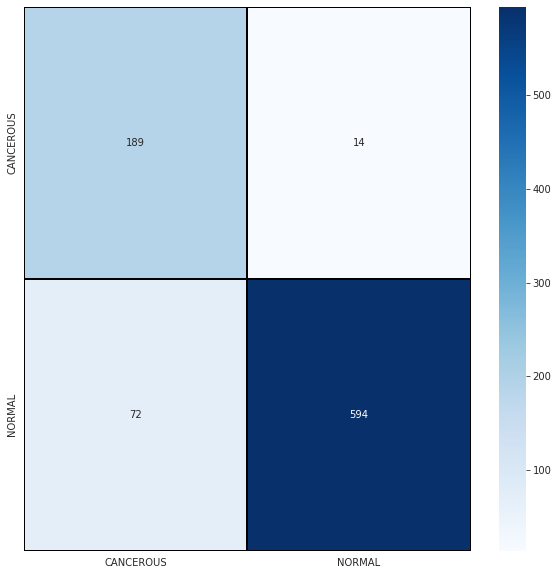

In [36]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In my final model, we see the test scores increase to 90.1% and recall increase to 89%. Despite a couple hesitations with previous models, I'm very satisfied with this model's performance. In fact, I would even recommend it as a viable preliminary detection technique to be used in the field. With 90% accuracy and 89% recall, only 1% of slides would be identified as falsely negative. 


## Conclusion 
---
A primary recommendation to my stakeholder would be to use this final model as a preliminary detection technique. Pathologists may spend literally hours on end scanning hundreds of whole slide images with a very real chance of coming across no malignant cells. Seeing the accuracy and recall of my model, I'm confident it has the ability to perform a preliminary scan, in a fraction of the time, to determine whether or not a patient's biopsy contains malignant cells. 

This helps address the business problem from multiple angles. It not only saves physicians time and reduces burnout, but it helps inform them specifically where they should expend their time and energy, reducing errors and misdiagnosis. Ultimately, this takes stress off the provider and helps the patient receive the highest-level quality of care. 



## Limitations and Next Steps 
---
Working with limited time and limited computing capacity, I was restricted in the numer of samples/patients I was able to analyze and train my model with. While I had access to over 100 patient's WSIs, I was only able to use a fraction of these, which could've skewed my data and made it less generalizable. Further, I didn't have access to any demographic information like age, sex, symptoms, etc. which I believe are features that could've helped create a more informed model. 

Moving forward, in addition to utilizing greater computing power, I believe that topographical and proximal location information on cells would be highly valuable information, allowing for the creation of a more accurate and precise model. Further, I would like to look into applying this model for diagnosis of other types of scans and cancers. 